# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy
import scipy.io as sio
import os
import glob
from scipy.stats import norm
import math
from scipy.stats import expon
# import arviz as az
# import pymc3 as pm
import pandas as pd
from datetime import datetime, timedelta
plt.rcParams.update({'font.size': 16})

# Load the data

In [2]:
#Change the directory
os.chdir('C:\\Users\\Jonathan\\Documents\\GitHub\\Split-Belt-AFC-Reliability\\Data\\TestRetest_PSI')

#Load the data
File_names = glob.glob("*.mat")

print('Files:')

Combined_data = []
for i, f in enumerate(File_names):
    Current_Subject = f[:-9]
    print(f)
    
    D = sio.loadmat(f)
    
    #Change these to 1d instead of 2
    D['AllResponses'] = D['AllResponses'][0]
    D['AllStarts'] = D['AllStarts'][0]
    D['AllStims'] = D['AllStims'][0]
    D['BinaryResponses'] = D['BinaryResponses'][0]
    D['alpha_EV'] = D['alpha_EV'][0]
    D['beta_EV'] = D['beta_EV'][0]

    #Trial Length
    Ntrials = len(D['BinaryResponses'])
    
    #Baseline difference
    D['BslDiff'] = np.ones_like(D['BinaryResponses'])*D['BslDiff'][0]
    #Subject ID and test number
    D['SID'] = [Current_Subject[:-1]]*Ntrials
    D['Test'] = [Current_Subject[-1]]*Ntrials
    
    #Start and end date time
    Test_Start = D.pop('PhaseStart')
    PhaseStart = datetime.strptime(Test_Start[0], "%d-%b-%Y %H:%M:%S")
    Test_Length = timedelta(seconds=D.pop('elapsedTime')[0][0])
    PhaseEnd = PhaseStart+Test_Length
    D['StartTime'] = [PhaseStart]*Ntrials
    D['EndTime'] = [PhaseEnd]*Ntrials
    
    #Delete the unnecessary keys
    del D['__header__'], D['__version__'], D['__globals__']
    
    #Create dataframe 
    currentDF = pd.DataFrame.from_dict(D)
    Combined_data.append(currentDF)
DF = pd.concat(Combined_data)

Files:
PSItest_15a_data.mat
PSItest_15b_data.mat
PSItest_16a_data.mat
PSItest_16b_data.mat
PSItest_17a_data.mat
PSItest_17b_data.mat
PSItest_18a_data.mat
PSItest_18b_data.mat
PSItest_19a_data.mat
PSItest_19b_data.mat
PSItest_20a_data.mat
PSItest_20b_data.mat


## Ensure equal start positions and test time

PSItest_15 a - Start Positions Equal (Top-Down= 25 ; Bottom-Up= 25 )
PSItest_15 b - Start Positions Equal (Top-Down= 25 ; Bottom-Up= 25 )
PSItest_16 a - Start Positions Unequal (Top-Down= 24 ; Bottom-Up= 25 )
PSItest_16 b - Start Positions Equal (Top-Down= 25 ; Bottom-Up= 25 )
PSItest_17 a - Start Positions Equal (Top-Down= 25 ; Bottom-Up= 25 )
PSItest_17 b - Start Positions Equal (Top-Down= 25 ; Bottom-Up= 25 )
PSItest_18 a - Start Positions Equal (Top-Down= 25 ; Bottom-Up= 25 )
PSItest_18 b - Start Positions Equal (Top-Down= 25 ; Bottom-Up= 25 )
PSItest_19 a - Start Positions Equal (Top-Down= 25 ; Bottom-Up= 25 )
PSItest_19 b - Start Positions Equal (Top-Down= 25 ; Bottom-Up= 25 )
PSItest_20 a - Start Positions Equal (Top-Down= 25 ; Bottom-Up= 25 )
PSItest_20 b - Start Positions Equal (Top-Down= 25 ; Bottom-Up= 25 )


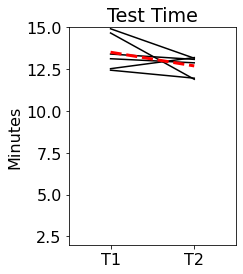

In [6]:
SIDs = pd.unique(DF.SID)
TNs = pd.unique(DF.Test)
Time = []
for i in range(len(SIDs)):
    
    T1 = DF.EndTime[(DF.SID==SIDs[i]) & (DF.Test=='a')][0] - DF.StartTime[(DF.SID==SIDs[i]) & (DF.Test=='a')][0]
    T2 = DF.EndTime[(DF.SID==SIDs[i]) & (DF.Test=='b')][0] - DF.StartTime[(DF.SID==SIDs[i]) & (DF.Test=='b')][0]
    Time.append([T1.total_seconds(), T2.total_seconds()])

    for t in range(len(TNs)):
        
        Starts = DF.AllStarts[(DF.SID==SIDs[i]) & (DF.Test==TNs[t])]
        Stims = DF.AllStims[(DF.SID==SIDs[i]) & (DF.Test==TNs[t])]
                
        TD = Starts > Stims 
        BU = Starts < Stims
        if sum(TD) == sum(BU):
            print(SIDs[i],  TNs[t], '- Start Positions Equal (Top-Down=', str(sum(TD)), '; Bottom-Up=', str(sum(BU)), ')')
        elif sum(TD) != sum(BU):
            print(SIDs[i],  TNs[t], '- Start Positions Unequal (Top-Down=', str(sum(TD)), '; Bottom-Up=', str(sum(BU)), ')')
    
Time = np.array(Time)
Time = Time/60

#Plot
plt.figure(figsize=(3,4))
plt.plot([np.ones(len(Time)), np.ones(len(Time))*2], [Time[:,0], Time[:,1]] ,'k-')
plt.plot([1, 2],[np.mean(Time[:,0]), np.mean(Time[:,1])],'r--',lw=3)
plt.xlim(0.5, 2.5)
plt.ylim(2, 15)
plt.xticks([1,2],['T1', 'T2'])
plt.title('Test Time')
plt.ylabel('Minutes')
plt.show()

# Visualize trials

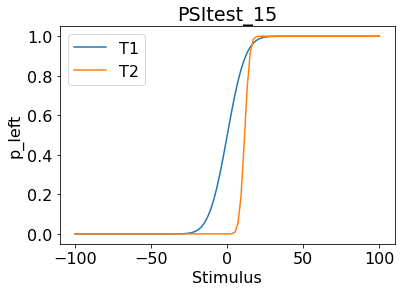

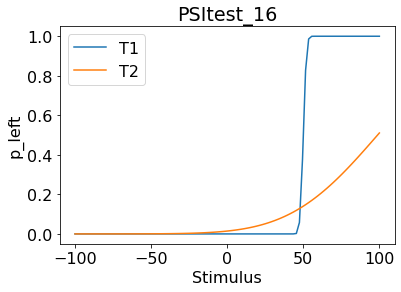

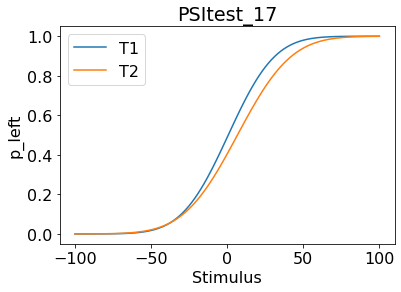

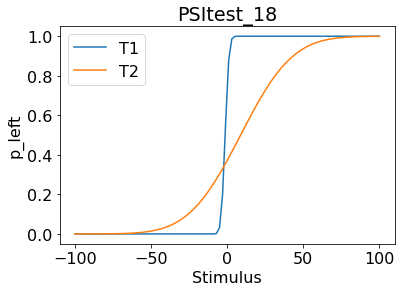

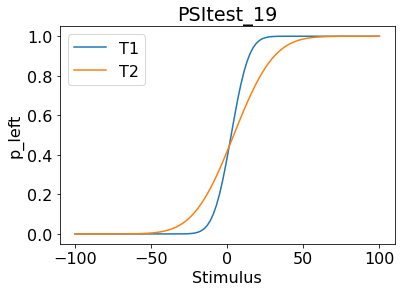

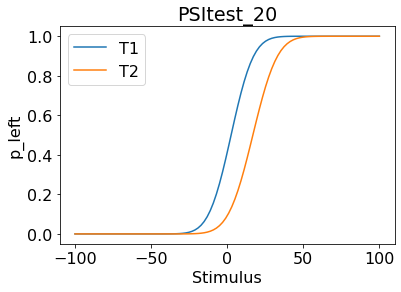

In [7]:
SIDs = pd.unique(DF.SID)
x = np.linspace(-100,100,100) #X-axis 

#initialize for parameters
alphas = []
betas = []
for i in range(len(SIDs)):
    fig, ax = plt.subplots()

    #Index baseline difference
    BD_a = round(DF.BslDiff[(DF.SID==SIDs[i]) & (DF.Test=='a')].values[0])
    BD_b = round(DF.BslDiff[(DF.SID==SIDs[i]) & (DF.Test=='b')].values[0])

    #index estimates for test 1 and 2
    aEV_a = DF.alpha_EV[(DF.SID==SIDs[i]) & (DF.Test=='a')].values[-1] + BD_a
    bEV_a = DF.beta_EV[(DF.SID==SIDs[i]) & (DF.Test=='a')].values[-1]

    aEV_b = DF.alpha_EV[(DF.SID==SIDs[i]) & (DF.Test=='b')].values[-1] + BD_b
    bEV_b = DF.beta_EV[(DF.SID==SIDs[i]) & (DF.Test=='b')].values[-1]

    #Store the estimates
    alphas.append([aEV_a, aEV_b])
    betas.append([bEV_a, bEV_b])
    
    #Calculate the psychometric functions
    psi_a = norm.cdf(x,aEV_a,bEV_a)
    psi_b = norm.cdf(x,aEV_b,bEV_b)
    
    #Index the 

    #Plot
    ax.plot(x,psi_a,label='T1')
    ax.plot(x,psi_b,label='T2')
    ax.legend()
    ax.set(title=SIDs[i],ylabel='p_left',xlabel='Stimulus')    
    plt.show() 
    
alphas = np.array(alphas)
betas = np.array(betas)

## Visualize each trial

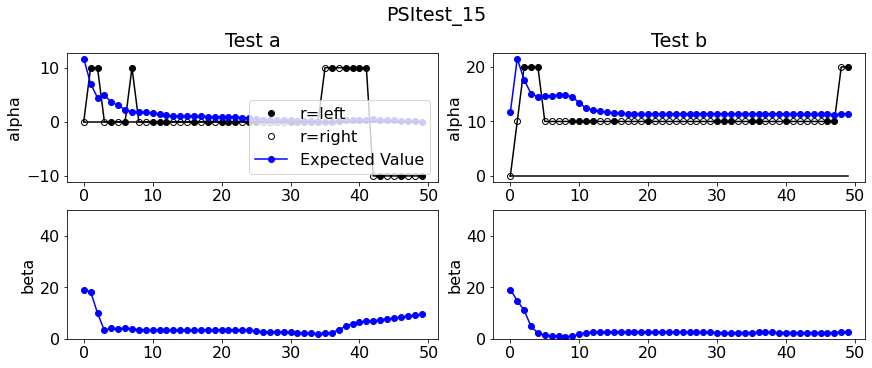

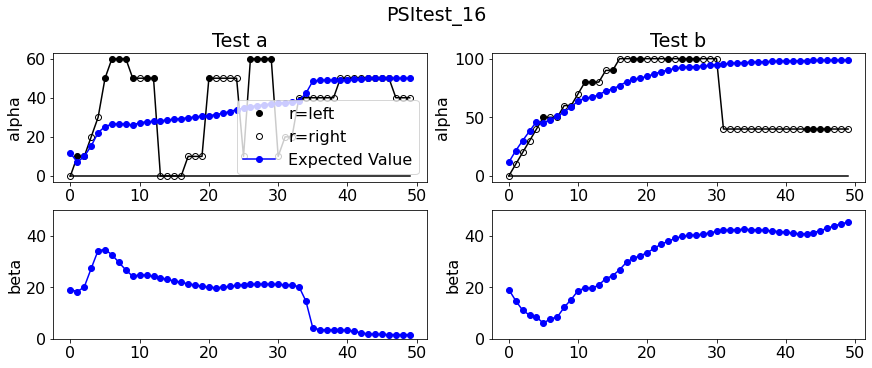

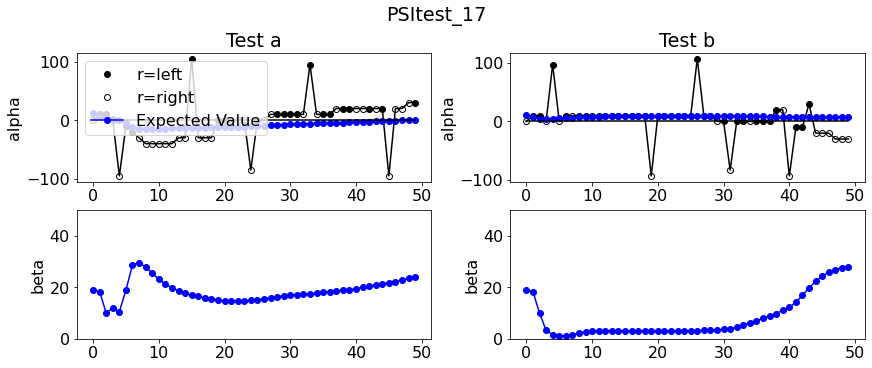

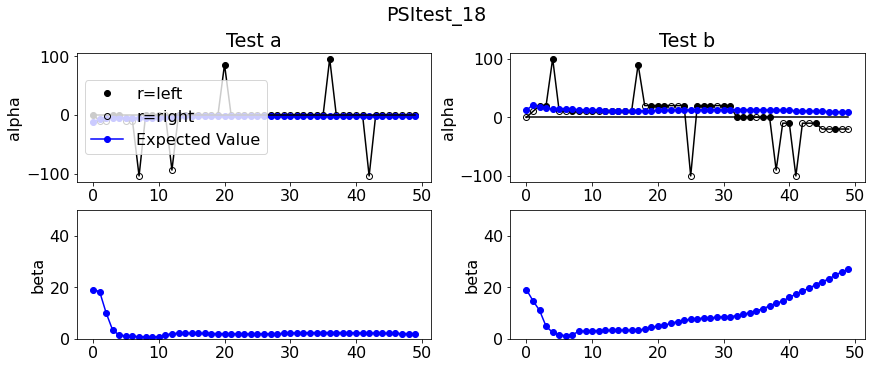

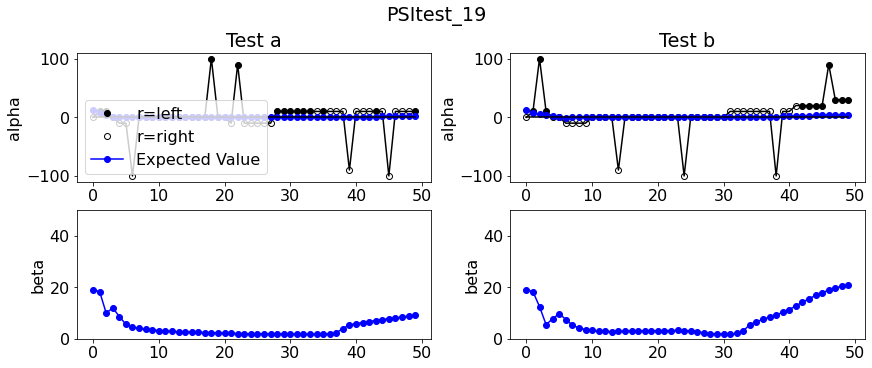

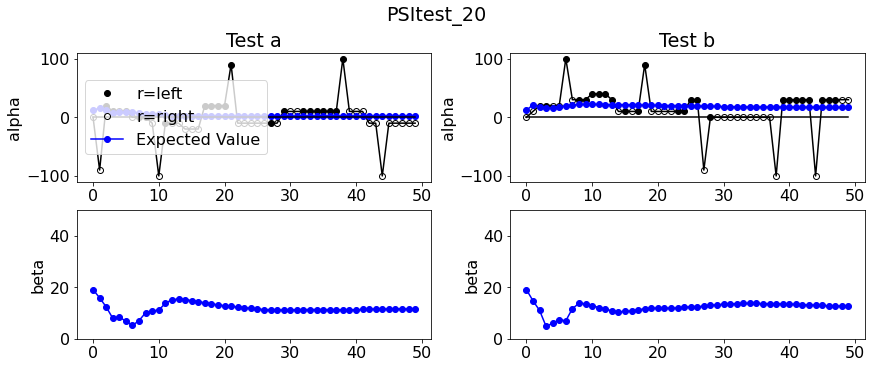

In [4]:
SIDs = pd.unique(DF.SID)
TNs = pd.unique(DF.Test)

for i in range(len(SIDs)):
    fig, ax = plt.subplots(2, 2, constrained_layout=True, figsize=(12,5))
    
    for t in range(len(TNs)):
        BslDiff = round(DF.BslDiff[(DF.SID==SIDs[i]) & (DF.Test==TNs[t])].values[0])

        Stims = np.array(DF.AllStims[(DF.SID==SIDs[i]) & (DF.Test==TNs[t])]+BslDiff)
        aEV = DF.alpha_EV[(DF.SID==SIDs[i]) & (DF.Test==TNs[t])]+BslDiff
        bEV = DF.beta_EV[(DF.SID==SIDs[i]) & (DF.Test==TNs[t])]

        Responses = DF.BinaryResponses[(DF.SID==SIDs[i]) & (DF.Test==TNs[t])].values

        L_response = np.argwhere(Responses==1)
        R_response = np.argwhere(Responses==0)
                                 
        ax[0,t].plot(Stims,'k-')
        ax[0,t].plot(L_response,Stims[Responses==1],'ko', linestyle='none', label='r=left')
        ax[0,t].plot(R_response,Stims[Responses==0],'ko', linestyle='none', fillstyle='none',label='r=right')
        ax[0,t].plot(aEV,'bo-', label='Expected Value')
        ax[0,t].plot(np.zeros(len(Stims)),'k-')
        ax[0,t].set(ylabel='alpha',title='Test '+ TNs[t])
        if t == 0:
            ax[0,t].legend()
        
        ax[1,t].plot(bEV,'bo-')
        ax[1,t].set(ylim=(0,50),ylabel='beta')
    
    fig.suptitle(SIDs[i])

## Visually compare the two psychometric functions 


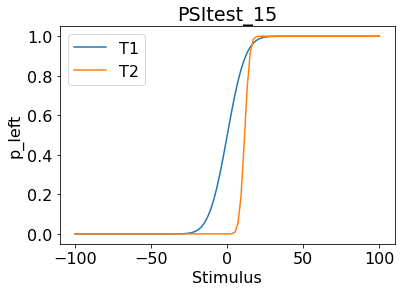

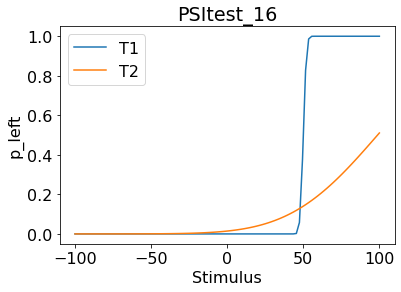

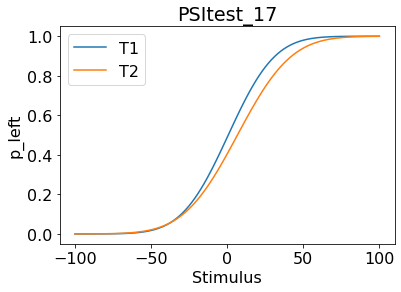

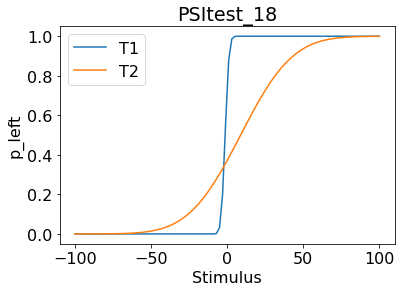

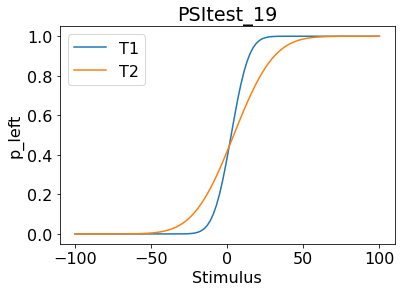

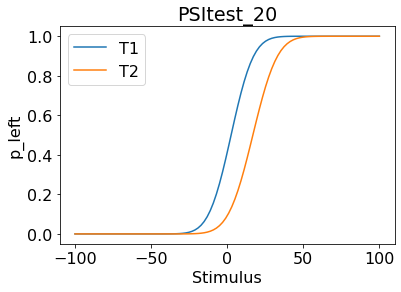

In [5]:
SIDs = pd.unique(DF.SID)
x = np.linspace(-100,100,100) #X-axis 

#initialize for parameters
alphas = []
betas = []
for i in range(len(SIDs)):
    fig, ax = plt.subplots()

    #Index baseline difference
    BD_a = round(DF.BslDiff[(DF.SID==SIDs[i]) & (DF.Test=='a')].values[0])
    BD_b = round(DF.BslDiff[(DF.SID==SIDs[i]) & (DF.Test=='b')].values[0])

    #index estimates for test 1 and 2
    aEV_a = DF.alpha_EV[(DF.SID==SIDs[i]) & (DF.Test=='a')].values[-1] + BD_a
    bEV_a = DF.beta_EV[(DF.SID==SIDs[i]) & (DF.Test=='a')].values[-1]

    aEV_b = DF.alpha_EV[(DF.SID==SIDs[i]) & (DF.Test=='b')].values[-1] + BD_b
    bEV_b = DF.beta_EV[(DF.SID==SIDs[i]) & (DF.Test=='b')].values[-1]

    #Store the estimates
    alphas.append([aEV_a, aEV_b])
    betas.append([bEV_a, bEV_b])
    
    #Calculate the psychometric functions
    psi_a = norm.cdf(x,aEV_a,bEV_a)
    psi_b = norm.cdf(x,aEV_b,bEV_b)
    
    #Index the 

    #Plot
    ax.plot(x,psi_a,label='T1')
    ax.plot(x,psi_b,label='T2')
    ax.legend()
    ax.set(title=SIDs[i],ylabel='p_left',xlabel='Stimulus')    
    plt.show() 
    
alphas = np.array(alphas)
betas = np.array(betas)

## Compare the parameters

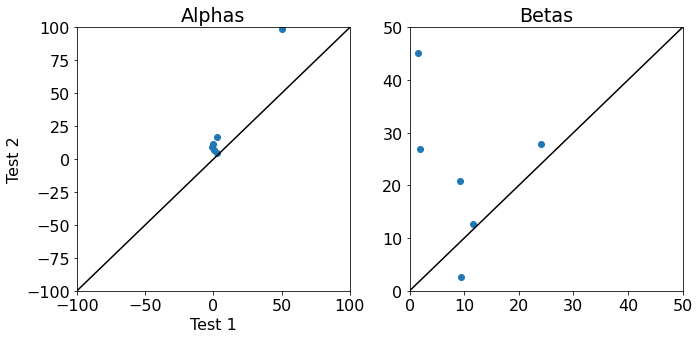

In [6]:
#Calculate CCC


#Plot the parameters
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(alphas[:,0],alphas[:,1],'o')
plt.plot(x,x,'k')
plt.ylim(-100,100)
plt.xlim(-100,100)
plt.title('Alphas')
plt.xlabel('Test 1')
plt.ylabel('Test 2')

plt.subplot(1,2,2)
plt.plot(betas[:,0],betas[:,1],'o')
plt.plot(x,x,'k')
plt.title('Betas')
plt.ylim(0, 50)
plt.xlim(0, 50)

plt.tight_layout()
plt.show()


## Fit the actual data as a spot check

In [7]:
import scipy.optimize as opt

def nloglik(params,X,N,K):
    '''
    This function returns the negative log likelihood of the parameters mu and sigma 
    for a data set 
    X = stimuli (vector)
    N = number of trials at each X 
    K = Number of trials with the response of interest
    '''   
    alpha=params[0]
    beta=params[1]
    
    phi = norm.cdf(X,alpha,beta)       
    ll = np.sum(K * np.log(phi) + ((N - K) * np.log(1-phi)))

    nll = -ll
    
    return nll

6
Optimization terminated successfully.
         Current function value: 63.662349
         Iterations: 65
         Function evaluations: 126
18
Optimization terminated successfully.
         Current function value: 53.967825
         Iterations: 79
         Function evaluations: 156
19


C:\Users\Jonathan\AppData\Local\Temp/ipykernel_2724/3185244842.py:15: RuntimeWarning: divide by zero encountered in log
  ll = np.sum(K * np.log(phi) + ((N - K) * np.log(1-phi)))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_2724/3185244842.py:15: RuntimeWarning: invalid value encountered in multiply
  ll = np.sum(K * np.log(phi) + ((N - K) * np.log(1-phi)))


15
Optimization terminated successfully.
         Current function value: 58.548198
         Iterations: 62
         Function evaluations: 120
9
Optimization terminated successfully.
         Current function value: 57.444254
         Iterations: 68
         Function evaluations: 135
18
Optimization terminated successfully.
         Current function value: 45.470258
         Iterations: 59
         Function evaluations: 112


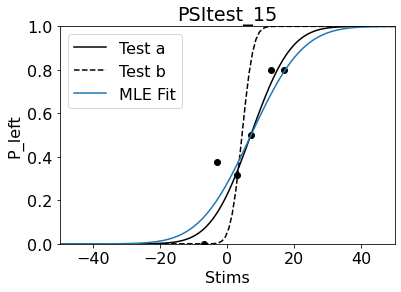

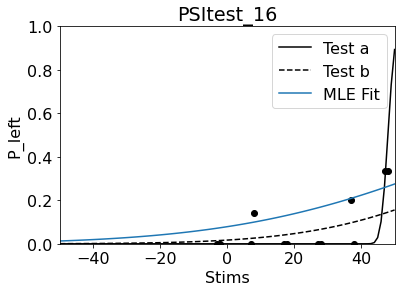

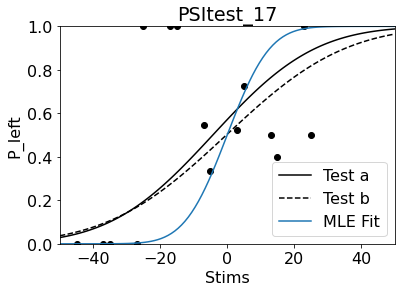

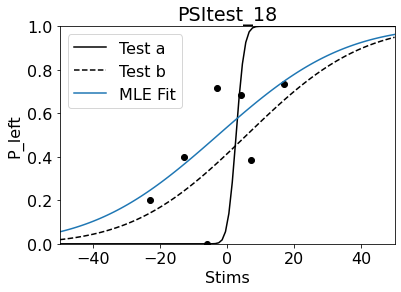

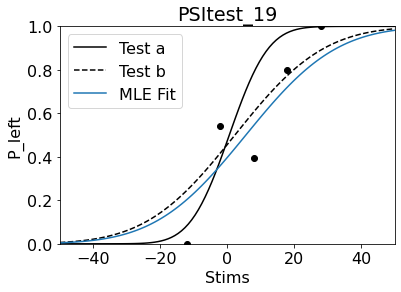

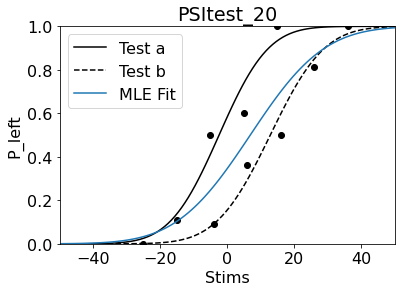

In [8]:
SIDs = pd.unique(DF.SID)
x = np.linspace(-50,50,100) #X-axis 

#initialize parameters
alphas = []
betas = []
for i in range(len(SIDs)):
    fig, ax = plt.subplots()

    #index estimates for test 1 and 2
    aEV_a = DF.alpha_EV[(DF.SID==SIDs[i]) & (DF.Test=='a')].values[-1] 
    bEV_a = DF.beta_EV[(DF.SID==SIDs[i]) & (DF.Test=='a')].values[-1]

    aEV_b = DF.alpha_EV[(DF.SID==SIDs[i]) & (DF.Test=='b')].values[-1]
    bEV_b = DF.beta_EV[(DF.SID==SIDs[i]) & (DF.Test=='b')].values[-1]

    #Calculate the psychometric functions
    psi_a = norm.cdf(x,aEV_a,bEV_a)
    psi_b = norm.cdf(x,aEV_b,bEV_b)   
    
    #Index the responses
    Responses =np.array(DF.BinaryResponses[(DF.SID==SIDs[i])])
    
    #Index baseline difference
    BD_a = round(DF.BslDiff[(DF.SID==SIDs[i]) & (DF.Test=='a')].values[0])
    BD_b = round(DF.BslDiff[(DF.SID==SIDs[i]) & (DF.Test=='b')].values[0])
    
    #Index the stimuli
    Stims_a = DF.AllStims[(DF.SID==SIDs[i]) & (DF.Test=='a')] 
    Stims_b = DF.AllStims[(DF.SID==SIDs[i]) & (DF.Test=='b')]
    
    Stims = np.concatenate((Stims_a,Stims_b))

    #Account for repeated stimuli 
    Unique_stims, stim_idx = np.unique(Stims, return_index=True)
    Unique_stims = Stims[np.sort(stim_idx)]
    Nstims = []
    Kleft = []
    for u in Unique_stims:
        stim_idx = np.argwhere(u==Stims)[:,0]
        Nstims = np.append(Nstims,len(stim_idx))
        Kleft = np.append(Kleft, np.sum(Responses[stim_idx]))
        
    P_left = Kleft / Nstims 
    print(len(Unique_stims))
    minimum = opt.fmin(nloglik, x0=[np.random.randint(-50,50),np.random.randint(1,50)], 
                       args = (Unique_stims,Nstims,Kleft),
                      full_output=True, maxfun=1e6, xtol=1e-6
                      )
    params = minimum[0]
    fit_alpha = params[0]
    fit_beta = params[1]
    psi_fit = norm.cdf(x,fit_alpha,fit_beta)
    
    ax.plot(Unique_stims,P_left,'ko')
    ax.plot(x,psi_a,'k-',label='Test a')
    ax.plot(x,psi_b,'k--',label='Test b')
    ax.plot(x,psi_fit,label='MLE Fit')
    ax.set(xlim=(-50,50),ylim=(0,1),title=SIDs[i],xlabel='Stims',ylabel='P_left')
    ax.legend()

# Probe the algorithm

## Recover stimulus positions

If I plug in the individuals responses and the stimulus values does the algoithm choose the same stimulus positions? I am finding that this is not the case. Why? Not sure, here are some possibilties:

* The look up table - I checked this, it is the same in python and matlab
* I am switching between matlab and python, there may be slight differences in rounding.
* The entropy calculation

Ok so after some investigation, I figured out that the issue was with the spacing of the alpha values. The spacing was less frequent for the python code vs the matlab code. The matlab code has them spaced at every possible alpha location. The result was more changes than what were provided during the experiment. This is acutally something I want to look at further, perhaps greater spacing of alpha values would help the algorthm select the next trials. 

### Define functions

In [4]:
#Look up table
def Psi_lookT(X,a_range,b_range):
    """
    This function creates two lookup tables required for the psi algorithm to run more efficiently
    It is a table of probabilities for both responses (left and right in this case) given all possible
    alpha and beta values and all possible stimulus locations:
    p(r='left'|alpha,beta,X)
    p(r='right'|alpha,beta,X)
    """
    #Set these nuisance parameters to nonzero values
    gam = 0.02
    lam = 0.02
    
    #Preallocate the lookup tables
    p_left_look = np.empty([len(b_range),len(a_range),(len(X))])
    p_right_look = np.empty([len(b_range),len(a_range),(len(X))])
    
    #Loop through all possible stimulus, alpha and beta values
    for x_i, x in enumerate(X):
        for a_i, a in enumerate(a_range):
            for b_i, b in enumerate(b_range):
                psi = gam + (1 - lam - gam) * norm.cdf(x,a,b)
                p_left_look[b_i,a_i,x_i] = psi
                p_right_look[b_i,a_i,x_i] = 1-psi

    return p_left_look, p_right_look

In [5]:
def UniqueVals(stims, responses):
    
    """
    This function takes stimulus values and responses and calculates N (total number of trials) and K (number of responses of interest) 
    for each unique stimulus values
    """
    
    Unique_stims, stim_idx = np.unique(stims, return_index=True)
    Unique_stims = stims[np.sort(stim_idx)]
    Nstims = []
    Kleft = []
    for u in Unique_stims:
        stim_idx = np.argwhere(u==stims)
        Nstims = np.append(Nstims,len(stim_idx))
        Kleft = np.append(Kleft, np.sum(responses[stim_idx]))
        
    return Unique_stims, Nstims, Kleft

In [6]:
#Entropy
def CalcH(X, p_left_look, p_right_look, Prior):

    """
    This function calculates the entropy (H) of each possible stimulus value to determine which one minimizes,
    the entropy for the next trial. This is the stimulus that will provide the most information for both parameters
    """
    
    #Simulate through each possible stim value, X
    EH = []
    for i, x in enumerate(X):

        #Calculate the probability of getting a response, r, after presenting test x at the next trial (across all possible parameter values)
        p_left = np.nansum(np.nansum(np.multiply(p_left_look[:,:,i],Prior)))
        p_right = np.nansum(np.nansum(np.multiply(p_right_look[:,:,i],Prior)))

        #Calculate the posterior for each response 
        # Post_left = np.multiply(Prior,p_left_look[:,:,i])
        Post_left = p_left_look[:,:,i]*Prior
        # Post_left = np.divide(Post_left, np.nansum(np.nansum(Post_left)))
        Post_left = Post_left / p_left
        # Post_right = np.multiply(Prior,p_right_look[:,:,i])
        Post_right = p_right_look[:,:,i]*Prior
        # Post_right = np.divide(Post_right, np.nansum(np.nansum(Post_right)))
        Post_right = Post_right / p_right

        #Estimate the entropy of the posterior distribution for each response
        # H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
        # H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
        H_left = -np.nansum(np.nansum(Post_left * np.log2(Post_left)))
        H_right = -np.nansum(np.nansum(Post_right * np.log2(Post_right)))
        
        #Combine the entropy calculations, weighted by their probabilities
        Total_H = (H_left*p_left) + (H_right*p_right)
        EH = np.append(EH, Total_H)
        
    best_X = X[np.argmin(EH)]
    return EH, best_X

In [7]:
def ConfirmStimChoice(SID,Test):
    
    #Index the participant info
    a_est = DF.alpha_EV[(DF.SID==SID) & (DF.Test==Test)].values
    b_est = DF.beta_EV[(DF.SID==SID) & (DF.Test==Test)].values
    Responses = DF.BinaryResponses[(DF.SID==SID) & (DF.Test==Test)].values
    Stims = DF.AllStims[(DF.SID==SID) & (DF.Test==Test)].values
    BslDiff = DF.BslDiff[(DF.SID==SID) & (DF.Test==Test)].values[0]

    X = np.arange(-100,110,10) - np.round(BslDiff)
    a_range = np.linspace(-100,100,201) - np.round(BslDiff)
    b_range = np.linspace(0.001,100,201)
    p_left_look, p_right_look = Psi_lookT(X,a_range,b_range)

    #Set the priors
    p_alpha = norm.pdf(a_range,-np.round(BslDiff),20)
    p_beta = expon.pdf(b_range,0,20)
    p_alpha = np.reshape(p_alpha,(1,len(p_alpha)))
    p_beta = np.reshape(p_beta,(1,len(p_beta)))
    Prior = p_beta.T @ p_alpha

    BestStims, diff_idx, stims, responses, alpha_EV, beta_EV, gam, lam = [],[],[],[],[],[], 0.02, 0.02
    for t in range(len(Responses)):

        EH, best_X = CalcH(X, p_left_look, p_right_look, Prior)
        BestStims = np.append(BestStims, best_X)

        if best_X != Stims[t] and Stims[t]>-80 and Stims[t]<80:
            diff_idx = np.append(diff_idx, t)

            fig, ax = plt.subplots(1,3,figsize=(15,5),tight_layout=True)
            ax[0].plot(X,EH,label='Best Stim = ' + str(best_X))
            ax[0].axvline(Stims[t],color='k',label='Actual Stim = ' + str(Stims[t]))
            ax[0].set(title='Entropy', xlabel='X',ylabel='Expected Entropy')
            ax[0].legend()    
            ax[1].contour(a_range,b_range,PrevPrior,1000)
            ax[1].set(xlabel='Alpha',ylabel='Beta',title='Prior')
            ax[2].contour(a_range,b_range,Posterior,1000)
            ax[2].set(xlabel='Alpha',ylabel='Beta',title='Posterior')
            plt.suptitle('Trial ' + str(t+1))
            plt.show()

        stims = np.append(stims, Stims[t])
        responses = np.append(responses, Responses[t])

        #Account for repeated stimuli 
        Unique_stims, Nstims, Kleft = UniqueVals(stims, responses)

        #Calcualte the likelihood for the response given the current parameters
        Likelihood = np.empty((len(b_range),len(a_range)))
        for a_idx, a in enumerate(a_range):
            for b_idx, b in enumerate(b_range):
                psi = gam + (1 - lam - gam)*norm.cdf(Unique_stims,a,b)
                Likelihood[b_idx,a_idx] = np.prod((psi**Kleft) * ((1-psi)**(Nstims-Kleft)))

        #Calculate the posterior
        Posterior = Likelihood*Prior
        Posterior = Posterior/np.nansum(np.nansum(Posterior))

        #Marginalize the posterior
        alpha_post = np.nansum(Posterior,axis=0)
        beta_post = np.nansum(Posterior,axis=1)

        #Calculate the expected value of each
        alpha_EV = np.append(alpha_EV, np.nansum(a_range*alpha_post))
        beta_EV = np.append(beta_EV, np.nansum(b_range*beta_post))

        #Save the prior
        PrevPrior = Prior    

        #The posterior becomes the prior for the next trial
        Prior = Posterior
        
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(Stims,'ro', linestyle='none', fillstyle='none', label='Experiment stims',alpha=0.5)
    ax.plot(BestStims,'bo', linestyle='none', fillstyle='none', label='Best stims',alpha=0.5)
    for x in diff_idx:
        ax.axvline(x,alpha=0.5)
    ax.plot(a_est,'r-', label='Alpha Estimate (experiment)',alpha=0.5)
    ax.plot(alpha_EV,'b-', label='Alpha Estimate (simulation)',alpha=0.5)
    ax.plot(b_est,'r--', label='Beta Estimate (experiment)',alpha=0.5)
    ax.plot(beta_EV,'b--', label='Beta Estimate (simulation)',alpha=0.5)
    ax.plot(np.zeros(len(Stims)),'k-')
    ax.set(ylim=(-30,30), ylabel='X',xlabel='trials',title='Stimulus Recovery')
    ax.legend()
    plt.show()

### Run the function 

Careful, this takes a long time to run

C:\Users\Jonathan\AppData\Local\Temp/ipykernel_15976/1857210654.py:30: RuntimeWarning: divide by zero encountered in log2
  H_left = -np.nansum(np.nansum(Post_left * np.log2(Post_left)))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_15976/1857210654.py:30: RuntimeWarning: invalid value encountered in multiply
  H_left = -np.nansum(np.nansum(Post_left * np.log2(Post_left)))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_15976/1857210654.py:31: RuntimeWarning: divide by zero encountered in log2
  H_right = -np.nansum(np.nansum(Post_right * np.log2(Post_right)))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_15976/1857210654.py:31: RuntimeWarning: invalid value encountered in multiply
  H_right = -np.nansum(np.nansum(Post_right * np.log2(Post_right)))


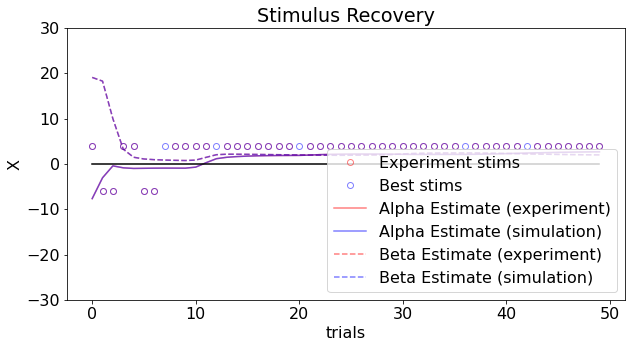

In [9]:
#Slect the subject and test you want to run
SID = 'PSItest_18'
Test = 'a'
#This function inputs the responses and stimulus positions to see if the same ones are recovered
ConfirmStimChoice(SID, Test)

## Simulate using the subjects paramters

### Define simulation function

In [17]:
#PSI simulation 
def SimulateSubj(SID,Test):
    
    #Index the participant info
    a_est = DF.alpha_EV[(DF.SID==SID) & (DF.Test==Test)].values
    b_est = DF.beta_EV[(DF.SID==SID) & (DF.Test==Test)].values
    BslDiff = DF.BslDiff[(DF.SID==SID) & (DF.Test==Test)].values[0]    
    Responses_exp = DF.BinaryResponses[(DF.SID==SID) & (DF.Test==Test)].values
    Stims_exp = DF.AllStims[(DF.SID==SID) & (DF.Test==Test)].values

    Ntrials = len(a_est)
    alpha = a_est[-1]
    beta = b_est[-1]
    gam = 0.02
    lam = 0.02

    X = np.arange(-100,110,10) - np.round(BslDiff)
    a_range = np.linspace(-100,100,201) - np.round(BslDiff)
    b_range = np.linspace(0.001,100,201)
    p_left_look, p_right_look = Psi_lookT(X,a_range,b_range)

    #Set the priors
    p_alpha = norm.pdf(a_range,-np.round(BslDiff),20)
    p_beta = expon.pdf(b_range,0,20)
    p_alpha = np.reshape(p_alpha,(1,len(p_alpha)))
    p_beta = np.reshape(p_beta,(1,len(p_beta)))
    Prior = p_beta.T @ p_alpha
    
    #initialize 
    stims,responses,alpha_EV,beta_EV = [],[],[],[]
    for t in range(Ntrials):
        
        #First simulate through each possible stim value, X, and calculate entropy
        _, best_X = CalcH(X, p_left_look, p_right_look, Prior)
        stims = np.append(stims, best_X)

        #Participant makes a selection
        P_left = gam + (1 - lam - gam)*norm.cdf(stims[t],alpha,beta)
        responses = np.append(responses, P_left > np.random.rand())
        
        #Account for repeated stimuli 
        Unique_stims, Nstims, Kleft = UniqueVals(stims, responses)

        #Calcualte the likelihood for the response given the current parameters
        Likelihood = np.empty((len(a_range),len(b_range)))
        for a_idx, a in enumerate(a_range):
            for b_idx, b in enumerate(b_range):
                psi = gam + (1 - lam - gam)*norm.cdf(Unique_stims,a,b)
                Likelihood[a_idx,b_idx] = np.prod((psi**Kleft) * ((1-psi)**(Nstims-Kleft)))
        
        #Calculate the posterior
        Posterior = Likelihood*Prior
        Posterior = Posterior/np.nansum(np.nansum(Posterior))
        
        #Marginalize the posterior
        alpha_post = np.nansum(Posterior,axis=1)
        beta_post = np.nansum(Posterior,axis=0)
        
        #Calculate the expected value of each
        alpha_EV = np.append(alpha_EV, np.nansum(a_range*alpha_post))
        beta_EV = np.append(beta_EV, np.nansum(b_range*beta_post))
        
        #The posterior becomes the prior for the next trial
        Prior = Posterior
        
    #Calculate responses
    US_sim, N_sim, Kleft_sim = UniqueVals(stims, responses)
    US_exp, N_exp, Kleft_exp = UniqueVals(Stims_exp, Responses_exp)

    #Calculate functions
    P_left_sim = gam + (1 - lam - gam)*norm.cdf(US_sim,alpha_EV[-1],beta_EV[-1])    
    P_left_exp = gam + (1 - lam - gam)*norm.cdf(US_exp,alpha,beta)
    
    fig, ax = plt.subplots()
    ax.plot(US_exp, (Kleft_exp/N_exp),'ko')
    ax.plot(US_exp, P_left_exp,'k',label='Experiment')
    ax.plot(US_sim, (Kleft_sim/N_sim),'ro')
    ax.plot(US_sim, P_left_sim,'r',label='Simulated')   
    plt.show()

### Simulate

C:\Users\Jonathan\AppData\Local\Temp/ipykernel_15976/1857210654.py:30: RuntimeWarning: divide by zero encountered in log2
  H_left = -np.nansum(np.nansum(Post_left * np.log2(Post_left)))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_15976/1857210654.py:30: RuntimeWarning: invalid value encountered in multiply
  H_left = -np.nansum(np.nansum(Post_left * np.log2(Post_left)))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_15976/1857210654.py:31: RuntimeWarning: divide by zero encountered in log2
  H_right = -np.nansum(np.nansum(Post_right * np.log2(Post_right)))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_15976/1857210654.py:31: RuntimeWarning: invalid value encountered in multiply
  H_right = -np.nansum(np.nansum(Post_right * np.log2(Post_right)))


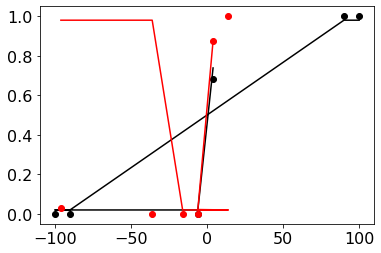

In [20]:
#Slect the subject and test you want to run
SID = 'PSItest_18'
Test = 'a'
SimulateSubj(SID,Test)